# 02. Textual geography 

This session will walk through some more advanced text processing and data wrangling to produce a map of the locations mentioned in our corpus. Topics covered include:

* Named entity recognition using Stanford's CRF-NER package.
* Geolocation using Google's mapping APIs.
* Cartographic visualization, both static (for print publication) and interactive (for online use).

## Named entity recognition

There are several approaches to identifying the places used in a piece of text. We could rely on a dictionary or gazetteer, which would tell us that Edinburgh is a city in Scotland, but would also tell us that Charlotte Brönte is a city in the United States.

We'll instead use statistical machine learning methods. While we *will* get an intro to machine learning this afternoon, for now we'll rely on the [implementation by the Stanford NLP group](http://nlp.stanford.edu/software/CRF-NER.html).

This is a Java package. It's possible -- with a lot of work -- to invoke Java code from Python. But there's no point in this case; it's much easier to invoke the NER package from the command line and to read in the plain text output.

Note that there do exist NER, POS, and other NLP packages for Python. NLTK -- the Natural Language Tool Kit, which we met in the last notebook when we used it for corpus processing -- is one of the most diverse and well conceived. But it's not optimized for speed and isn't notably accurate compared to more production-oriented offerings. 

There's a guide to using the NER package on Stanford's site. Here's the short version, for reference:

```
java -mx1g -cp "*:lib/*" edu.stanford.nlp.ie.crf.CRFClassifier
-loadClassifier classifiers/english.all.3class.distsim.crf.ser.gz 
-outputFormat tabbedEntities 
-textFile file.txt > file.tsv
```

This runs the English-language classifier over a single text file. Note that we need to have a classifier trained for the language of the text we're processing. Stanford has trained models for English, Spanish, German, Chinese, and other major languages, but they're lacking French and a great many other languages.

The classifier's output follows a tabbed format that looks like this:

```
                Why did the poor poet of
Tennessee       LOCATION        , upon suddenly receiving two handfuls of silver , deliberate whether to buy him a coat , which he sadly needed , or invest his money in a pedestrian trip to
Rockaway Beach  LOCATION        ?
```

The thing to notice is that every line begins with two tabs, but only the text in front of the first tab is a recognized entity. The text in front of the second tab, then, indicates the type of entity: PERSON, ORGANIZATION, or LOCATION. Any text following the second tab is body text, presumed not to contain any named entities.

So let's recreate our corpus, then read in the tagged files and get a list of the locations used in the corpus.

### Recreate the corpus

In [252]:
# Suppress compatibility warnings
import warnings
warnings.filterwarnings('ignore')

In [253]:
import pandas as pd
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

text_dir = '../Data/Texts/'
corpus = PlaintextCorpusReader(text_dir, '.*\.txt')

# A function to turn fileids into a table of metadata
def parse_fileids(fileids):
    '''Takes a list of file names formatted like A-Cather-Antonia-1918-F.txt.
       Returns a pandas dataframe of derived metadata.'''
    import pandas as pd
    meta = {}
    for fileid in fileids:
        file = fileid.strip('.txt') # Get rid of file suffix
        fields = file.split('-') # Split on dashes
        fields[2] = fields[2].replace('_', ' ') # Remove underscore from titles
        fields[3] = int(fields[3])
        meta[file] = fields
    metadata = pd.DataFrame.from_dict(meta, orient='index') # Build dataframe
    metadata.columns = ['nation', 'author', 'title', 'pubdate', 'gender'] # Col names
    return metadata.sort_index() # Note we need to sort b/c datframe built from dictionary

def collect_stats(corpus):
    '''Takes an NLTK corpus as input. 
       Returns a pandas dataframe of stats indexed to fileid.'''
    import nltk
    import pandas as pd
    stats = {}
    for fileid in corpus.fileids():
        word_count = len(corpus.words(fileid))
        stats[fileid.strip('.txt')] = {'wordcount':word_count}
    statistics = pd.DataFrame.from_dict(stats, orient='index')
    return statistics.sort_index()

books = parse_fileids(corpus.fileids())
stats = collect_stats(corpus)
books = books.join(stats)
books.index.set_names('file', inplace=True)
books.head()

,nation,author,title,pubdate,gender,wordcount
file,,,,,,
A-Cather-Antonia-1918-F,A,Cather,Antonia,1918,F,97574
A-Chesnutt-Marrow-1901-M,A,Chesnutt,Marrow,1901,M,110288
A-Crane-Maggie-1893-M,A,Crane,Maggie,1893,M,28628
A-Davis-Life_Iron_mills-1861-F,A,Davis,Life Iron mills,1861,F,18789
A-Dreiser-Sister_Carrie-1900-M,A,Dreiser,Sister Carrie,1900,M,194062


### Read and parse NER-tagged files

The taged NER files are in the `..Data/NER/` directory. We need a function that will parse each one and return just the locations for further processing. 

In [2]:
import pandas as pd
import numpy as np

def get_loc(line):
    '''Takes a string of NER output. 
       Returns a location if found, else None.'''
    line = line.split('\t')
    try:
        if line[1] == 'LOCATION':
            return line[0]
        else:
            return None
    except:
        return None

def ingest_ner(f):
    '''Take a file handle for an NER output file.
       Returns a dict of locations and counts.'''
    from collections import defaultdict
    locations = defaultdict(lambda: 0)
    for line in f:
        loc = get_loc(line)
        if loc:
            locations[loc] += 1
    return locations

In [3]:
import os
ner_dir = '../Data/NER/'

files_list =[]
locs_list = []
occurs_list = []

for fileid in sorted(corpus.fileids()):
    file = os.path.join(ner_dir, fileid)
    with open(file) as f:
        locations = ingest_ner(f)
        for loc in sorted(locations, key=locations.get, reverse=True):
            files_list.append(fileid.strip('.txt'))
            locs_list.append(loc)
            occurs_list.append(locations[loc])

In [4]:
d = {'file': files_list, 
     'location': locs_list,
     'occurs': occurs_list}
geo = pd.DataFrame(d)
print(geo.describe())
geo.head()

            occurs
count  3439.000000
mean      4.178831
std      15.361014
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max     495.000000


,file,location,occurs
0,A-Cather-Antonia-1918-F,Black Hawk,21
1,A-Cather-Antonia-1918-F,Nebraska,16
2,A-Cather-Antonia-1918-F,Virginia,13
3,A-Cather-Antonia-1918-F,Omaha,10
4,A-Cather-Antonia-1918-F,Chicago,10


In [5]:
# Total number of named location occurrences in corpus
geo.occurs.sum()

14371

In [6]:
geo = geo.join(books, on='file')
geo.head()

,file,location,occurs,nation,author,title,pubdate,gender,wordcount
0,A-Cather-Antonia-1918-F,Black Hawk,21,A,Cather,Antonia,1918,F,97574
1,A-Cather-Antonia-1918-F,Nebraska,16,A,Cather,Antonia,1918,F,97574
2,A-Cather-Antonia-1918-F,Virginia,13,A,Cather,Antonia,1918,F,97574
3,A-Cather-Antonia-1918-F,Omaha,10,A,Cather,Antonia,1918,F,97574
4,A-Cather-Antonia-1918-F,Chicago,10,A,Cather,Antonia,1918,F,97574


In [7]:
places = geo.groupby('location')

In [8]:
places.occurs.aggregate(np.sum).head()

location
ASIA                  1
AUGUSTUS MELMOTTE     1
Abchurch Lane        27
Abingdon              1
Abingdon Street       1
Name: occurs, dtype: int64

In [9]:
places.occurs.size().head()

location
ASIA                 1
AUGUSTUS MELMOTTE    1
Abchurch Lane        1
Abingdon             1
Abingdon Street      1
dtype: int64

In [10]:
place_counts = pd.DataFrame(places.occurs.aggregate(np.sum))
place_counts['volumes'] = places.occurs.size()
print(place_counts.describe())
place_counts.head()

            occurs      volumes
count  2365.000000  2365.000000
mean      6.076533     1.454123
std      30.206909     1.580908
min       1.000000     1.000000
25%       1.000000     1.000000
50%       1.000000     1.000000
75%       3.000000     1.000000
max    1042.000000    23.000000


,occurs,volumes
location,,
ASIA,1,1
AUGUSTUS MELMOTTE,1,1
Abchurch Lane,27,1
Abingdon,1,1
Abingdon Street,1,1


In [202]:
lookups = place_counts[(place_counts['occurs']>5) & (place_counts['volumes']>1)]
lookups.describe()

,occurs,volumes
count,198.000000,198.000000
mean,35.363636,4.929293
std,93.222833,3.837439
min,6.000000,2.000000
25%,8.000000,2.000000
50%,14.000000,4.000000
75%,27.000000,6.000000
max,1042.000000,23.000000


In [203]:
lookups.head()

,occurs,volumes
location,,
Africa,36,8
Albany,7,4
America,83,20
Andes,8,2
Asia,6,3


## Perform geocoding

In [13]:
# Parameters for geocoding clients
# NOTE: Per-second query rates will quickly use up daily API quota.
#   Need to be careful not to exceed daily quota

import googlemaps

gc_rate  =     50 # Geocoding queries per second
pl_rate  =      5 # Places queries per second
api_key_file = '/Users/mwilkens/Google Drive/Private/google-geo-api-key.txt'

# Get API key from file
try:
    api_key = open(api_key_file).read().strip()
except:
    sys.exit('Cannot get Google geocoding API key. Exiting.')

gc_client = googlemaps.Client(key=api_key, queries_per_second=gc_rate) # For Geocoding API
pl_client = googlemaps.Client(key=api_key, queries_per_second=pl_rate) # For Places API

In [61]:
# A function to get place_ids from strings
def get_placeid(string, api_client):
    '''Takes a string and an established googlemaps places API client.
       Returns first place_id associated with that string.
       If not place_id found, returns "ZERO_RESULTS" or None, depending on result status code.'''
    try:
        place = api_client.places(string)
        status = place['status']
        if status == 'OK':
            place_id = place['results'][0]['place_id']
        elif status == 'ZERO_RESULTS':
            place_id = None
        else:
            place_id = None
    except:
        place_id = None
    return place_id

def process_id(placeid, api_client):
    '''Takes a Google place_id and an established googlemaps geocoding API client.
        Looks up and parses geo data for placeid.
        Returns int code on error, else dictionary of geo data.
    '''
    # Define all variables, initial to None
    result = {
    'formatted_address' : None,
    'location_type' : None,
    'country' : None,
    'admin_1' : None,
    'admin_2' : None,
    'locality' : None,
    'colloquial_area' : None,
    'continent' : None,
    'natural_feature' : None,
    'point_of_interest' : None,
    'lat' : None,
    'lon' : None,
    'partial' : None,
    }
    # Perform reverse geocode. Note this needs googlemaps v 2.4.2-dev0 or higher
    try:
        data = gc_client.reverse_geocode(placeid)
    except:
        return 1 # Problem with geocoding API call
    
    # Use the first result. Should only be one when reverse geocoding with place_id.
    try:
        data = data[0]
        result['formatted_address'] = data['formatted_address']
        result['location_type'] = data['types'][0]
        result['lat'] = data['geometry']['location']['lat']
        result['lon'] = data['geometry']['location']['lng']
        try:
            result['partial'] = result['partial_match']
        except:
            result['partial'] = False
    except:
        print("   Bad geocode for place_id %s" % (placeid))
        return 2 # Problem with basic geocode result
    
    try:
        for addr_comp in data['address_components']:
            comp_type = addr_comp['types'][0]
            if comp_type == 'locality':
                result['locality'] = addr_comp['long_name']
            elif comp_type == 'country':
                result['country'] = addr_comp['long_name']
            elif comp_type == 'administrative_area_level_1':
                result['admin_1'] = addr_comp['long_name']
            elif comp_type == 'administrative_area_level_2':
                result['admin_2'] = addr_comp['long_name']
            elif comp_type == 'colloquial_area':
                result['colloquial_area'] = addr_comp['long_name']
            elif comp_type == 'natural_feature':
                result['natural_feature'] = addr_comp['long_name']
            elif comp_type == 'point_of_interest':
                result['point_of_interest'] = addr_comp['long_name']
            elif comp_type == 'continent':
                result['continent'] = addr_comp['long_name']
    except:
        return 3 # Problem with address components
     
    ### Code to build results dictionary here
    
    return result

In [204]:
%%time

placeids = {}
for loc in lookups.index:
    plid = get_placeid(loc, pl_client)
    placeids[loc] = plid
    
placeids = pd.DataFrame.from_dict(placeids, orient='index')
placeids.columns = ['placeid']
placeids.index.set_names('location', inplace=True)

CPU times: user 4.26 s, sys: 282 ms, total: 4.55 s
Wall time: 2min 6s


In [ ]:
# Uncomment to read good data from disk
#placeids = pd.read_csv('../Results/placeids.csv', index_col=0)

In [210]:
placeids.to_csv('../Results/placeids.csv')
placeids.head()

,placeid
location,
America,ChIJCzYy5IS16lQRQrfeQ5K5Oxw
Europe,ChIJhdqtz4aI7UYRefD8s-aZ73I
Jackson Street,ChIJw34Q38OAhYARULF5jDe-8cE
Hudson,ChIJbU_L8ymU3YkRzaqMXJfLnmQ
Waterloo,ChIJ3xjvH7NN5YcRGOs8-41AWeg


In [211]:
%%time

geodata = {}
for plid in placeids['placeid']:
    if plid:
        geodata[plid] = process_id(plid, gc_client)

   Bad geocode for place_id ChIJPcTFENIEdkgR94E58rgB69o
CPU times: user 4.31 s, sys: 262 ms, total: 4.57 s
Wall time: 30.6 s


In [212]:
geodata_df = pd.DataFrame.from_dict(geodata)
geodata_df = geodata_df.transpose()
geodata_df.index.set_names('placeid', inplace=True)
geodata_df.head()

,admin_1,admin_2,colloquial_area,continent,country,formatted_address,lat,locality,location_type,lon,natural_feature,partial,point_of_interest
placeid,,,,,,,,,,,,,
ChIJ-Y7t-qm02IcRW-C7IsrqOb4,Missouri,None,None,None,United States,"St. Louis, MO, USA",38.627,St. Louis,locality,-90.1994,None,False,None
ChIJ-_Xhli0FdkgRwYbM2r7CmPA,England,Greater London,None,None,United Kingdom,"Grosvenor Square Garden, Mayfair, London W1K 4...",51.5115,London,establishment,-0.15147,None,False,None
ChIJ-bDD5__lhVQRuvNfbGh4QpQ,Washington,None,None,None,United States,"Washington, USA",47.7511,None,administrative_area_level_1,-120.74,None,False,None
ChIJ-yRniZpWPEURE_YRZvj9CRQ,None,None,None,None,Russia,Russia,61.524,None,country,105.319,None,False,None
ChIJ-ydAXOS6WUgRCPTbzjQSfM8,None,None,None,None,Ireland,Ireland,53.4129,None,country,-8.24389,None,False,None


In [ ]:
# Uncomment to read good data from disk
#geodata_df = pd.read_csv('../Results/geodata_df.csv', index_col=0)

In [213]:
geodata_df.to_csv('../Results/geodata_df.csv')

In [214]:
# Put all the data together
placeids_geo = placeids.join(geodata_df, on='placeid')
placeids_geo.head()

,placeid,admin_1,admin_2,colloquial_area,continent,country,formatted_address,lat,locality,location_type,lon,natural_feature,partial,point_of_interest
location,,,,,,,,,,,,,,
America,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,None,None,None,None,United States,United States,37.0902,None,country,-95.7129,None,False,None
Europe,ChIJhdqtz4aI7UYRefD8s-aZ73I,None,None,None,Europe,None,Europe,54.526,None,continent,15.2551,None,False,None
Jackson Street,ChIJw34Q38OAhYARULF5jDe-8cE,California,San Francisco County,None,None,United States,"Jackson St, San Francisco, CA, USA",37.7933,San Francisco,route,-122.428,None,False,None
Hudson,ChIJbU_L8ymU3YkRzaqMXJfLnmQ,New York,Columbia County,None,None,United States,"Hudson, NY 12534, USA",42.2529,Hudson,locality,-73.791,None,False,None
Waterloo,ChIJ3xjvH7NN5YcRGOs8-41AWeg,Iowa,Black Hawk County,None,None,United States,"Waterloo, IA, USA",42.4928,Waterloo,locality,-92.3426,None,False,None


In [215]:
geo_all = geo.join(placeids_geo, on='location')
print(geo_all.shape)
geo_all.head()

(3439, 23)


,file,location,occurs,nation,author,title,pubdate,gender,wordcount,placeid,...,continent,country,formatted_address,lat,locality,location_type,lon,natural_feature,partial,point_of_interest
0,A-Cather-Antonia-1918-F,Black Hawk,21,A,Cather,Antonia,1918,F,97574,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A-Cather-Antonia-1918-F,Nebraska,16,A,Cather,Antonia,1918,F,97574,ChIJ7fwMtciNk4cRxArzDwyQJ6E,...,None,United States,"Nebraska, USA",41.4925,None,administrative_area_level_1,-99.9018,None,False,None
2,A-Cather-Antonia-1918-F,Virginia,13,A,Cather,Antonia,1918,F,97574,ChIJzbK8vXDWTIgRlaZGt0lBTsA,...,None,United States,"Virginia, USA",37.4316,None,administrative_area_level_1,-78.6569,None,False,None
3,A-Cather-Antonia-1918-F,Omaha,10,A,Cather,Antonia,1918,F,97574,ChIJ7fwMtciNk4cRBLY3rk9NQkY,...,None,United States,"Omaha, NE, USA",41.2524,Omaha,locality,-95.998,None,False,None
4,A-Cather-Antonia-1918-F,Chicago,10,A,Cather,Antonia,1918,F,97574,ChIJ7cv00DwsDogRAMDACa2m4K8,...,None,United States,"Chicago, IL, USA",41.8781,Chicago,locality,-87.6298,None,False,None


## Make maps

In [216]:
# Setup
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import os

sns.set_style("whitegrid")
sns.set_context("talk")

figDir = '../Results/'

In [217]:
# Munge data

# Just cities
cities = geo_all[(geo_all['location_type'] == 'locality')].groupby('location')

cities_tot = [int(i) for i in cities.occurs.sum()]
cities_lon = [i for i in cities.lon.max()]
cities_lat = [i for i in cities.lat.max()]

In [245]:
def bubblemap(lats, lons, sizes, color, name):
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import os

    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    
    ax.set_extent([-170, 170, -60, 80])
    #sizes      = [i/50 for i in sizes]

    plt.scatter(lons, lats, s=sizes, linewidths=0,
                color=color, marker='o', alpha=0.4, transform=ccrs.Geodetic())

    ax.add_feature(cfeature.COASTLINE, linewidth=1.5, alpha=1.0)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray')

    plt.tight_layout()
    plt.savefig(os.path.join(figDir, name)+'.png', dpi=300)

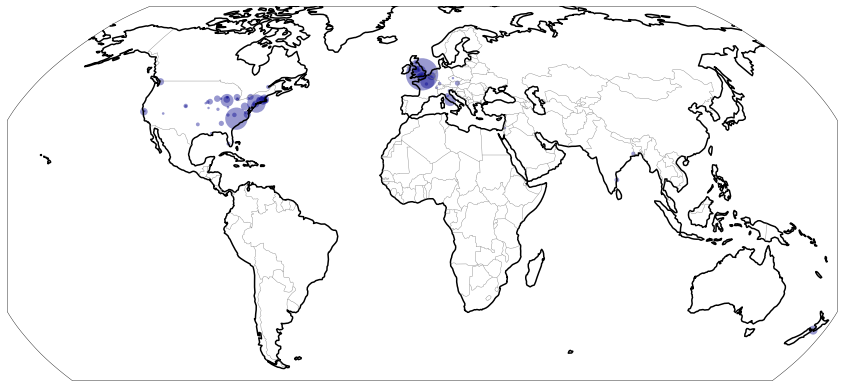

In [254]:
bubblemap(cities_lat, cities_lon, cities_tot, 'darkblue', 'map-cities-corpus')

In [220]:
cities.occurs.sum().sort_values(ascending=False).head(10)

location
London        1042
Charlotte      497
New York       338
Paris          205
Chicago        167
Leicester      141
Rome           135
Boston          83
Wellington      80
Providence      73
Name: occurs, dtype: int64

In [225]:
geo_all[geo_all['location']=='Charlotte']

,file,location,occurs,nation,author,title,pubdate,gender,wordcount,placeid,...,continent,country,formatted_address,lat,locality,location_type,lon,natural_feature,partial,point_of_interest
503,A-James-Golden_Bowl-1904-M,Charlotte,495,A,James,Golden Bowl,1904,M,257750,ChIJgRo4_MQfVIgRZNFDv-ZQRog,...,None,United States,"Charlotte, NC, USA",35.2271,Charlotte,locality,-80.8431,None,False,None
1818,B-Dickens-Bleak_House-1853-M,Charlotte,2,B,Dickens,Bleak House,1853,M,435141,ChIJgRo4_MQfVIgRZNFDv-ZQRog,...,None,United States,"Charlotte, NC, USA",35.2271,Charlotte,locality,-80.8431,None,False,None


In [310]:
# Aggregated places by nation
nations = geo_all[(geo_all['country'].notnull())].groupby('country')

countries_tot = [int(i) for i in nations.occurs.sum()]
countries_lon = [i for i in nations.lon.apply(np.mean)]
countries_lat = [i for i in nations.lat.apply(np.mean)]

In [331]:
# Create labels for country counts (used later)
countries_lab = [i for i in nations.country.groups]
countries_lab = [str(i) for i in countries_lab]
countries_lab = sorted(countries_lab)
for i in range(len(countries_lab)):
    countries_lab[i] = countries_lab[i] + ': ' + str(countries_tot[i])

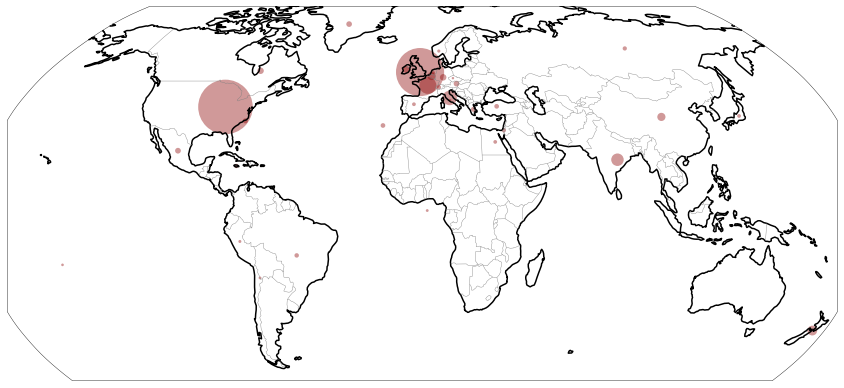

In [251]:
bubblemap(countries_lat, countries_lon, countries_tot, 'darkred', 'map-nations-corpus')

In [235]:
# UK vs US nation-level attention
brit = geo_all[(geo_all['nation'] == 'B')].groupby('country')
amer = geo_all[(geo_all['nation'] == 'A')].groupby('country')

brit_tot = [int(i) for i in brit.occurs.sum()]
brit_lon = [i for i in brit.lon.apply(np.mean)]
brit_lat = [i for i in brit.lat.apply(np.mean)]

amer_tot = [int(i) for i in amer.occurs.sum()]
amer_lon = [i for i in amer.lon.apply(np.mean)]
amer_lat = [i for i in amer.lat.apply(np.mean)]

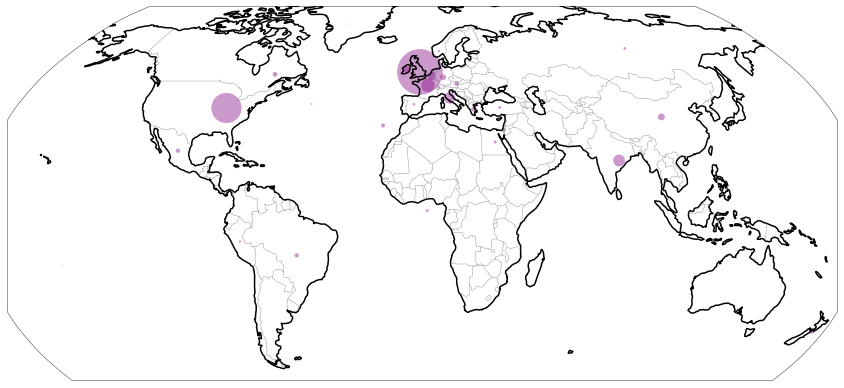

In [255]:
bubblemap(brit_lat, brit_lon, brit_tot, 'purple', 'map-nations-brit')

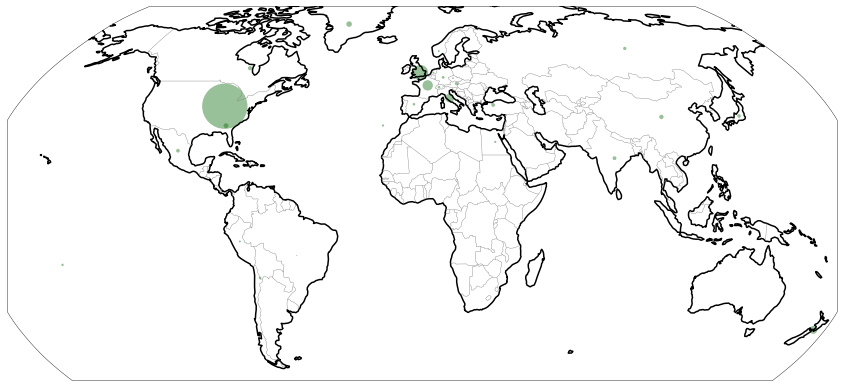

In [256]:
bubblemap(amer_lat, amer_lon, amer_tot, 'darkgreen', 'map-nations-amer')

## Interactive

In [337]:
# Note that Folium needs to *serve* the output files, not just open them in a browser
#  Start a python web server with 
#   python3 -m http.server 8080 --bind localhost
#  in the figure directory. The load output page in browser like
#   http://localhost:8080/map-nations.html

import folium
folium.initialize_notebook()

map = folium.Map(location=[0, 0], zoom_start=2)
marker_size = 100000000

for i in range(len(countries_lab)):
    map.circle_marker(location=[countries_lat[i], countries_lon[i]],
                      radius=np.sqrt(countries_tot[i]*marker_size),
                      popup=countries_lab[i])

map.create_map(path=os.path.join(figDir, 'map-nations.html'))
map

In [342]:
geo_all[geo_all['country']=='Portugal']

,file,location,occurs,nation,author,title,pubdate,gender,wordcount,placeid,...,continent,country,formatted_address,lat,locality,location_type,lon,natural_feature,partial,point_of_interest
474,A-Howells-Silas_Lapham-1885-M,Madeira,1,A,Howells,Silas Lapham,1885,M,163414,ChIJ7y75-KDpXwwRb166dGfldww,...,None,Portugal,"Madeira, Portugal",32.7607,None,administrative_area_level_1,-16.9595,None,False,None
1103,A-Norris-Pit-1903-M,Madeira,3,A,Norris,Pit,1903,M,157730,ChIJ7y75-KDpXwwRb166dGfldww,...,None,Portugal,"Madeira, Portugal",32.7607,None,administrative_area_level_1,-16.9595,None,False,None
1462,A-Wharton-Age_Innocence-1920-F,Madeira,1,A,Wharton,Age Innocence,1920,F,124177,ChIJ7y75-KDpXwwRb166dGfldww,...,None,Portugal,"Madeira, Portugal",32.7607,None,administrative_area_level_1,-16.9595,None,False,None
1494,B-Bronte-Jane_Eyre-1847-F,Madeira,9,B,Bronte,Jane Eyre,1847,F,227994,ChIJ7y75-KDpXwwRb166dGfldww,...,None,Portugal,"Madeira, Portugal",32.7607,None,administrative_area_level_1,-16.9595,None,False,None
1915,B-Dickens-Bleak_House-1853-M,Madeira,1,B,Dickens,Bleak House,1853,M,435141,ChIJ7y75-KDpXwwRb166dGfldww,...,None,Portugal,"Madeira, Portugal",32.7607,None,administrative_area_level_1,-16.9595,None,False,None
2122,B-Disraeli-Sybil-1845-M,Madeira,1,B,Disraeli,Sybil,1845,M,189057,ChIJ7y75-KDpXwwRb166dGfldww,...,None,Portugal,"Madeira, Portugal",32.7607,None,administrative_area_level_1,-16.9595,None,False,None
2717,B-Thackeray-Vanity_Fair-1848-M,Madeira,6,B,Thackeray,Vanity Fair,1848,M,367914,ChIJ7y75-KDpXwwRb166dGfldww,...,None,Portugal,"Madeira, Portugal",32.7607,None,administrative_area_level_1,-16.9595,None,False,None
